# 2023 Fall AI605 Assignment 1: Recurrent Neural Networks

## Rubric

### Deadline

The deadline for this assignment is: Friday 22nd September 2023 (Week 4) 11:59pm

### Submission

Please submit your assignment via [KLMS](https://klms.kaist.ac.kr). You must submit the Jupyter Notebook file (.ipynb) with all code and model outputs.

Use in-line LaTeX for mathematical expressions.

### Collaboration

This assignment is an individual assingnment. It is **not** a group assignment so make sure your answer and code are your own.

### Grading

The total number of marks avaiable is 25 points.

### Environment

The use of a GPU is not required for this notebook. The suggested environment for this is Python 3.9. Run the following cell to set up the environment.

### Data

All problems will use the stanford sentiment treebank dataset. However, pre-procesing it can take a bit of work https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip. To save time, we will use the Huggingface implementation of the dataset: https://huggingface.co/datasets/sst

### Libraries

The following libraries should be used for the project. You should not need any other libraries.


In [1]:
# !pip install torch tqdm datasets

# Problem 1 - MLP vs RNN (5 points)


This problem will make use of the stanford sentiment treebank dataset. We can load and partition the data with the following code


In [1]:
import datasets
from itertools import islice

sst = datasets.load_dataset("sst")


def score_to_label(score):
    if score < 0.2:
        return "strong negative"
    elif score < 0.4:
        return "negative"
    elif score < 0.6:
        return "neutral"
    elif score < 0.8:
        return "positive"
    else:
        return "strong positive"


def score_to_idx(score):
    if score < 0.2:
        return 0
    elif score < 0.4:
        return 1
    elif score < 0.6:
        return 2
    elif score < 0.8:
        return 3
    else:
        return 4


for instance in islice(sst["train"], 5):
    print("Raw Instance:", instance)
    print("Tokens:", instance["tokens"].split("|"))
    print("Label:", score_to_label(instance["label"]))
    print("***")
    print()

Generating train split:   0%|          | 0/8544 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1101 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2210 [00:00<?, ? examples/s]

Raw Instance: {'sentence': "The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .", 'label': 0.6944400072097778, 'tokens': "The|Rock|is|destined|to|be|the|21st|Century|'s|new|``|Conan|''|and|that|he|'s|going|to|make|a|splash|even|greater|than|Arnold|Schwarzenegger|,|Jean-Claud|Van|Damme|or|Steven|Segal|.", 'tree': '70|70|68|67|63|62|61|60|58|58|57|56|56|64|65|55|54|53|52|51|49|47|47|46|46|45|40|40|41|39|38|38|43|37|37|69|44|39|42|41|42|43|44|45|50|48|48|49|50|51|52|53|54|55|66|57|59|59|60|61|62|63|64|65|66|67|68|69|71|71|0'}
Tokens: ['The', 'Rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'Century', "'s", 'new', '``', 'Conan', "''", 'and', 'that', 'he', "'s", 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'Arnold', 'Schwarzenegger', ',', 'Jean-Claud', 'Van', 'Damme', 'or', 'Steven', 'Segal', '.']
Label: positive
***

Raw Instance: {'sente

Below is an implementation of a dataset and classifier:

### Read the data


In [ ]:
UNK_TOKEN = "<UNK>"
PAD_TOKEN = "<PAD>"
word_to_idx = dict()
word_to_idx[PAD_TOKEN] = 0
for instance in sst["train"]:
    tokens = instance["tokens"].split("|")
    for token in tokens:
        token = token.lower()
        if token not in word_to_idx:
            word_to_idx[token] = len(word_to_idx)


word_to_idx[UNK_TOKEN] = len(word_to_idx)
print(word_to_idx)

### Load the data into a dataset object

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html


In [6]:
from torch.utils.data import Dataset


class SSTDataset(Dataset):
    def __init__(self, vocab, partition):
        super().__init__()
        self.instances = [
            {
                "tokens": instance["tokens"].split("|"),
                "token_idxs": [
                    vocab.get(token.lower(), vocab.get(UNK_TOKEN))
                    for token in instance["tokens"].split("|")
                ],
                "label": score_to_label(instance["label"]),
                "label_idx": score_to_idx(instance["label"]),
            }
            for instance in sst[partition]
        ]

        print("Loaded:", partition, len(self.instances))
        print("Example:", self.instances[0])
        print()

    def __len__(self):
        return len(self.instances)

    def __getitem__(self, idx):
        return self.instances[idx]["token_idxs"], self.instances[idx]["label_idx"]


train = SSTDataset(word_to_idx, "train")
validation = SSTDataset(word_to_idx, "validation")

print("Example model input/output")
print(train[100])

Loaded: train 8544
Example: {'tokens': ['The', 'Rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'Century', "'s", 'new', '``', 'Conan', "''", 'and', 'that', 'he', "'s", 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'Arnold', 'Schwarzenegger', ',', 'Jean-Claud', 'Van', 'Damme', 'or', 'Steven', 'Segal', '.'], 'token_idxs': [1, 2, 3, 4, 5, 6, 1, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 9, 17, 5, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33], 'label': 'positive', 'label_idx': 3}

Loaded: validation 1101
Example: {'tokens': ['It', "'s", 'a', 'lovely', 'film', 'with', 'lovely', 'performances', 'by', 'Buy', 'and', 'Accorsi', '.'], 'token_idxs': [132, 9, 19, 4074, 266, 93, 4074, 433, 83, 3873, 14, 16582, 33], 'label': 'positive', 'label_idx': 3}

Example model input/output
([132, 3, 913, 19, 914, 5, 1, 915, 14, 53, 37, 1, 916, 33], 3)


### Make Dataloader


In [7]:
from torch.utils.data import DataLoader
from torch.nn.functional import pad
import torch


def pad_and_collate(batch):
    Xs = [item[0] for item in batch]
    ys = [item[1] for item in batch]

    # Find longest input
    longest_x = max(len(x) for x in Xs)

    # Fill remaining space in all other inputs with a 0 padding token
    X_tensors = [pad(torch.LongTensor(x), (0, longest_x - len(x)), value=0) for x in Xs]

    # Create one large matrix of Xs
    X_tensors = torch.stack(X_tensors)
    y_tensors = torch.stack([torch.LongTensor([y]) for y in ys]).squeeze()

    return X_tensors, y_tensors


train_loader = DataLoader(
    train, batch_size=32, shuffle=True, collate_fn=pad_and_collate
)
validation_loader = DataLoader(
    validation, batch_size=32, shuffle=True, collate_fn=pad_and_collate
)

### Define Model


In [49]:
from torch import nn
from torch import functional as F

num_embeddings = len(word_to_idx)
num_labels = 5
embedding_size = 100
hidden_size = 50


class MLPBaseline(nn.Module):
    def __init__(self, num_embeddings, num_labels, embedding_dim, hidden_dim):
        super(MLPBaseline, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim, padding_idx=0)

        self.linear1 = nn.Linear(embedding_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim)

        self.nonlinear = torch.tanh
        self.cls_layer = nn.Linear(hidden_dim, num_labels)

    def forward(self, input_tensor):
        emb = self.embedding(input_tensor)
        summed = self.nonlinear(emb.mean(axis=-2))
        hidden = self.nonlinear(self.linear1(summed))
        hidden = self.nonlinear(self.linear2(hidden))
        hidden = self.nonlinear(self.linear3(hidden))

        logits = self.cls_layer(hidden)
        return logits


baseline = MLPBaseline(num_embeddings, num_labels, embedding_size, hidden_size)

sample_input = torch.LongTensor(train[100][0])
logits = baseline(sample_input)

print("Per class predictions on sample from model")
print(logits)

print("Selected class")
print(torch.argmax(logits).item())

print("Actual class")
print(train[100][1])

print("Cross entropy loss")
ce = nn.CrossEntropyLoss()
# Note that the cross entropy loss function expects a batch of inputs, hence using unsqueeze function to make a batch of 1 item.
ce(logits.unsqueeze(0), torch.LongTensor([train[100][1]]))

Per class predictions on sample from model
tensor([0.0333, 0.0581, 0.0712, 0.1170, 0.0473], grad_fn=<ViewBackward0>)
Selected class
3
Actual class
3
Cross entropy loss


tensor(1.5582, grad_fn=<NllLossBackward0>)

### Train the model


In [50]:
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import LinearLR

num_epochs = 6
baseline = MLPBaseline(num_embeddings, num_labels, embedding_size, hidden_size)
optimizer = Adam(baseline.parameters(), lr=0.005)
scheduler = LinearLR(optimizer, total_iters=num_epochs)

# Training loop
for epoch in range(num_epochs):
    train_loss_total = 0
    train_acc_hits = 0
    train_count = 0

    valid_loss_total = 0
    valid_acc_hits = 0
    valid_count = 0

    # Sample a batch of sentences Xs and labels ys from the dataset
    for Xs, ys in train_loader:
        optimizer.zero_grad()

        # Make a prediction and estimate the loss
        prediction = baseline(Xs)
        loss = ce(prediction, ys)

        # Compute changes for each parameter w.r.t. loss and update model
        loss.backward()
        optimizer.step()

        # Compute accuracy and average loss for reporting
        train_count += Xs.shape[0]
        train_loss_total += loss.item()
        train_acc_hits += torch.count_nonzero(
            torch.argmax(prediction, dim=-1) == ys
        ).item()

    with torch.no_grad():
        for Xs, ys in validation_loader:
            prediction = baseline(Xs)
            loss = ce(prediction, ys)

            valid_count += Xs.shape[0]
            valid_loss_total += loss.item()
            valid_acc_hits += torch.count_nonzero(
                torch.argmax(prediction, dim=-1) == ys
            ).item()

    scheduler.step()

    print("Epoch: ", epoch)
    print("Average training loss:", train_loss_total / train_count)
    print("Average training acc:", train_acc_hits / train_count)
    print()
    print("Average validation loss:", valid_loss_total / valid_count)
    print("Average validation acc:", valid_acc_hits / valid_count)
    print()
    print()

Epoch:  0
Average training loss: 0.048203452389115255
Average training acc: 0.31062734082397003

Average validation loss: 0.04714240744155066
Average validation acc: 0.3478655767484105


Epoch:  1
Average training loss: 0.043250743871771
Average training acc: 0.39232209737827717

Average validation loss: 0.04422772277170263
Average validation acc: 0.3832879200726612


Epoch:  2
Average training loss: 0.0364966235552611
Average training acc: 0.4874765917602996

Average validation loss: 0.04603513699028299
Average validation acc: 0.40054495912806537


Epoch:  3
Average training loss: 0.029745224270313866
Average training acc: 0.6036985018726592

Average validation loss: 0.05035406324021065
Average validation acc: 0.3505903723887375


Epoch:  4
Average training loss: 0.022978426644418123
Average training acc: 0.7210908239700374

Average validation loss: 0.06000980326092102
Average validation acc: 0.3478655767484105


Epoch:  5
Average training loss: 0.01685592338219564
Average training ac

**Problem 1.1** (1 point) In your own words. Describe the architecture of the provided model. Does the model capture sentence ordering? How is the meaning of the sentence represented?


The provided model is an MLP model with:

- An embedding layer that converts input token indices into dense vectors.
- A non-linear transformation (tanh) applied to the mean of the embeddings to get a sentence representation.
- Three linear layers followed by $\tanh$ activations to further process the sentence representation.
- A final classification layer to predict sentiment scores.

Because it takes the mean of the embeddings, the model does not capture sentence ordering and hence loses word sequence information. The average of a sentence's word embeddings is used to convey its meaning, which means that context between words is not explicitly tracked.


**Problem 1.2** (1 point) Add dropout to the model and select an appropriate value of dropout probability. How does this affect the model accuracy?


In [8]:
from torch import nn
from torch import functional as F

num_embeddings = len(word_to_idx)
num_labels = 5
embedding_size = 100
hidden_size = 50


class MLPBaselineWithDropout(nn.Module):
    def __init__(
        self, num_embeddings, num_labels, embedding_dim, hidden_dim, dropout_p
    ):
        super(MLPBaselineWithDropout, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim, padding_idx=0)

        self.dropout = nn.Dropout(dropout_p)

        self.linear1 = nn.Linear(embedding_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim)

        self.nonlinear = torch.tanh
        self.cls_layer = nn.Linear(hidden_dim, num_labels)

    def forward(self, input_tensor):
        emb = self.embedding(input_tensor)
        summed = self.nonlinear(emb.mean(axis=-2))

        hidden = self.dropout(self.nonlinear(self.linear1(summed)))
        hidden = self.dropout(self.nonlinear(self.linear2(hidden)))
        hidden = self.dropout(self.nonlinear(self.linear3(hidden)))

        logits = self.cls_layer(hidden)
        return logits

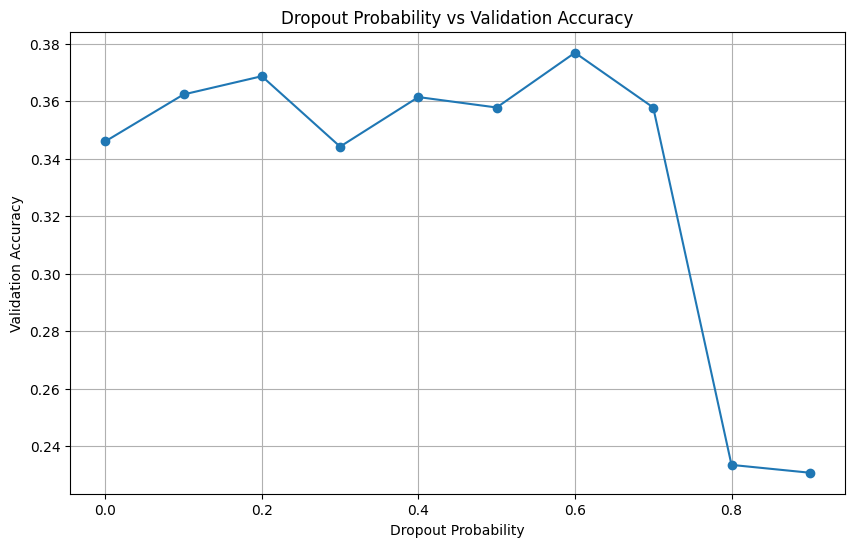

In [9]:
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import LinearLR
import matplotlib.pyplot as plt
from statistics import fmean


dropout_p_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
val_accuracies = []

criterion = nn.CrossEntropyLoss()

for dropout_p in dropout_p_values:
    num_epochs = 6
    for i in range(20):
        baseline = MLPBaselineWithDropout(
            num_embeddings, num_labels, embedding_size, hidden_size, dropout_p
        ).to()
        optimizer = Adam(baseline.parameters(), lr=0.005)
        scheduler = LinearLR(optimizer, total_iters=num_epochs)

        tmp_val_accuracies = []

        # Training loop
        for epoch in range(num_epochs):
            train_loss_total = 0
            train_acc_hits = 0
            train_count = 0

            valid_loss_total = 0
            valid_acc_hits = 0
            valid_count = 0

            # Sample a batch of sentences Xs and labels ys from the dataset
            for Xs, ys in train_loader:
                optimizer.zero_grad()

                # Make a prediction and estimate the loss
                prediction = baseline(Xs)
                loss = criterion(prediction, ys)

                # Compute changes for each parameter w.r.t. loss and update model
                loss.backward()
                optimizer.step()

                # Compute accuracy and average loss for reporting
                train_count += Xs.shape[0]
                train_loss_total += loss.item()
                train_acc_hits += torch.count_nonzero(
                    torch.argmax(prediction, dim=-1) == ys
                ).item()

            with torch.no_grad():
                for Xs, ys in validation_loader:
                    prediction = baseline(Xs)
                    loss = criterion(prediction, ys)

                    valid_count += Xs.shape[0]
                    valid_loss_total += loss.item()
                    valid_acc_hits += torch.count_nonzero(
                        torch.argmax(prediction, dim=-1) == ys
                    ).item()

            scheduler.step()

            val_accuracy = valid_acc_hits / valid_count

        tmp_val_accuracies.append(val_accuracy)

    val_accuracies.append(fmean(tmp_val_accuracies))

plt.figure(figsize=(10, 6))
plt.plot(dropout_p_values, val_accuracies, marker="o")
plt.title("Dropout Probability vs Validation Accuracy")
plt.xlabel("Dropout Probability")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()

Dropouts are known to improve model generalisation and prevent overfitting. In this experiment, dropout was added into the model with a range of probabilities [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]. Each probability was tested 20 times to account for variability. The results indicated that a dropout probability of 0.6 yielded the highest validation accuracy. However, it was observed that for dropout values exceeding 0.7, there was a significant decline in validation accuracy, suggesting that a too high dropout rate negatively impacted the model's learning capability.


**Problem 1.3** (3 points) Replace part of a model which aggregates the sentence meaning with an RNN encoder. Retrain the model and report the validation set accuracy.

There are several valid ways to use the RNN cell. Chose an appropriate representation and justify your choice in your own words.

The documentation for the RNN module is here: https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

**Common bug: check the batch_first parameter is set**


In [43]:
class RNNBaseline(nn.Module):
    def __init__(self, num_embeddings, num_labels, embedding_dim, hidden_dim):
        super(RNNBaseline, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, embedding_dim, batch_first=True)

        self.linear1 = nn.Linear(embedding_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim)

        self.nonlinear = torch.tanh
        self.cls_layer = nn.Linear(hidden_dim, num_labels)

    def forward(self, input_tensor):
        emb = self.embedding(input_tensor)

        out, _ = self.rnn(emb)
        rnn_out = out[:, -1, :]

        hidden = self.nonlinear(self.linear1(rnn_out))
        hidden = self.nonlinear(self.linear2(hidden))
        hidden = self.nonlinear(self.linear3(hidden))

        logits = self.cls_layer(hidden)
        return logits

In [44]:
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import LinearLR

num_epochs = 6

num_embeddings = len(word_to_idx)
num_labels = 5
embedding_size = 100
hidden_size = 50

rnn_base = RNNBaseline(num_embeddings, num_labels, embedding_size, hidden_size)
optimizer = Adam(rnn_base.parameters(), lr=0.005)
scheduler = LinearLR(optimizer, total_iters=num_epochs)

# Training loop
for epoch in range(num_epochs):
    train_loss_total = 0
    train_acc_hits = 0
    train_count = 0

    valid_loss_total = 0
    valid_acc_hits = 0
    valid_count = 0

    # Sample a batch of sentences Xs and labels ys from the dataset
    for Xs, ys in train_loader:
        optimizer.zero_grad()

        # Make a prediction and estimate the loss
        prediction = rnn_base(Xs)
        loss = ce(prediction, ys)

        # Compute changes for each parameter w.r.t. loss and update model
        loss.backward()
        optimizer.step()

        # Compute accuracy and average loss for reporting
        train_count += Xs.shape[0]
        train_loss_total += loss.item()
        train_acc_hits += torch.count_nonzero(
            torch.argmax(prediction, dim=-1) == ys
        ).item()

    with torch.no_grad():
        for Xs, ys in validation_loader:
            prediction = rnn_base(Xs)
            loss = ce(prediction, ys)

            valid_count += Xs.shape[0]
            valid_loss_total += loss.item()
            valid_acc_hits += torch.count_nonzero(
                torch.argmax(prediction, dim=-1) == ys
            ).item()

    scheduler.step()

    print("Epoch: ", epoch)
    print("Average training loss:", train_loss_total / train_count)
    print("Average training acc:", train_acc_hits / train_count)
    print()
    print("Average validation loss:", valid_loss_total / valid_count)
    print("Average validation acc:", valid_acc_hits / valid_count)
    print()
    print()

Epoch:  0
Average training loss: 0.04313669292332974
Average training acc: 0.26556647940074907

Average validation loss: 0.04357356390662891
Average validation acc: 0.25340599455040874


Epoch:  1
Average training loss: 0.0427569311377261
Average training acc: 0.2646301498127341

Average validation loss: 0.04410148478983533
Average validation acc: 0.26248864668483196


Epoch:  2
Average training loss: 0.04275690374916859
Average training acc: 0.26322565543071164

Average validation loss: 0.04356815888598006
Average validation acc: 0.25340599455040874


Epoch:  3
Average training loss: 0.0429028466846166
Average training acc: 0.2624063670411985

Average validation loss: 0.04417558099658353
Average validation acc: 0.26248864668483196


Epoch:  4
Average training loss: 0.04295396522971128
Average training acc: 0.27153558052434457

Average validation loss: 0.04389173631555486
Average validation acc: 0.20799273387829245


Epoch:  5
Average training loss: 0.04297022545214896
Average training

In this modified model, an RNN layer is introduced to replace the aggregation of sentence meaning done previously by averaging embeddings. The RNN can capture sequential information in the sentence, potentially providing richer sentence representations. The final hidden state of the RNN is used to represent the whole sentence. This representation is then fed into the linear layers to predict the label, as it captures the sequential interactions of the sentence tokens, and should contain the overall contextual information of the entire sentence.


# Problem 2 - Recurrent Model as an Autoregressive Language Model (10 points)


**Problem 2.1** (1 point) In your own words, describe the RNN neural network architecture. Use equations where appropriate (max 100 words)


The RNN architecture is designed to process sequential data by maintaining a hidden state $h_t$ that carries information from previous time steps. The core equation for standard RNN is:

$$h_t = \sigma(U^\top h_{t-1} + V^\top x_t)$$

Here, $x_t$ is the input at time step $t$, $h_{t-1}$ is the hidden state from the previous time step, and $U, V$ are trainable parameters shared between time steps. The hidden state $h_t$ serves as the memory of the network, allowing it to capture information from past inputs in the sequence. The final output at time step $n$ is usually computed as $y_n = \text{Softmax}(W^\top h_n)$.


**Problem 2.2** (2 points) In your own words. State what the the vanishing gradient problem with RNNs is. How to LSTMs differ from RNNs? How does this difference mitigate the vanishing gradient problem? Use equations where appropriate. (max 200 words)


The vanishing gradient problem in RNNs occurs during training when gradients of the loss function w.r.t. the parameters become very small for long sequences, causing the weights not to update effectively, hence learning long-term dependencies becomes challenging. This happens because during backpropagation through time, gradients are multiplied by the weight matrices at each time step, and if the weights are small the gradients shrink exponentially.

LSTMs are a type of RNN designed to mitigate the vanishing gradient problem. Unlike standard RNNs, LSTMs have a more complex internal structure involving three gates: an input gate, a forget gate, and an output gate, along with a cell state. The equations for an LSTM are as follows:

$$
\begin{align*}
I_t &= \sigma(W_{xi}^\top x_t + W_{hi}^\top h_{t-1})\\
F_t &= \sigma(W_{xf}^\top x_t + W_{hf}^\top h_{t-1})\\
O_t &= \sigma(W_{xo}^\top x_t + W_{ho}^\top h_{t-1})\\
\tilde{C}_t &= \tanh(W_{xc}^\top x_t + W_{hc}^\top h_{t-1})\\
C_t &= F_t * C_{t-1} + I_t * \tilde{C}_t\\
h_t &= O_t * \tanh(C_t)
\end{align*}
$$

Here, $*$ denotes elementwise multiplication. The cell state $C_t$ in LSTMs allows the network to maintain long-term dependencies, and the gating mechanisms help in adaptively controlling the flow of information, mitigating the vanishing gradient problem by allowing gradients to flow unchanged through the network.


**Problem 2.3** (1 point) Consider a sequence of tokens $W=(w_1, w_2,\ldots,w_T)$ with $T$ tokens. Discuss how teacher forcing can be used to train a language model to predict $w_t | w_1, \ldots, w_{t-1}$ (max 100 words). Write the maximum likelihood criterion for training the model for this sequence with teacher forcing.


In teacher forcing, during training, the true previous tokens $w_1, w_2, \ldots, w_{t-1}$ are fed as inputs at each time step $t$ to train the model to predict the next token $w_t$. It accelerates training as the model receives accurate historical context.

The maximum likelihood criterion for this sequence with teacher forcing can be represented as:

$$
\mathcal{L} = -\sum_{t=1}^{T} \log P(w_t | w_1, w_2, \ldots, w_{t-1}; \theta)
$$

Where $\mathcal{L}$ is the loss to be minimised, and $\theta$ represents the parameters of the model.


**Problem 2.4** (5 points) Implement and train an autoregressive LSTM language model using the sentences from the provided SST dataset. Treat each sentence in the dataset independently. Report the training and validation loss for a maximum of 20 epochs. Select appropriate model dimensions.

- Hint: it would be beneficial to include special tokens to mark the start and end of sequences.
- Hint: it may be beneficial to compute the loss for a single string considering all tokens in a single call to the model rather than perform many independent predictions.

Documentation: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html


In [9]:
from torch.utils.data import Dataset


# Extend vocabulary
if "<SOS>" not in word_to_idx:
    word_to_idx["<SOS>"] = len(word_to_idx)
if "<EOS>" not in word_to_idx:
    word_to_idx["<EOS>"] = len(word_to_idx)


class SSTDataset2(Dataset):
    def __init__(self, vocab, partition):
        super().__init__()
        sos_idx = vocab.get("<SOS>")
        eos_idx = vocab.get("<EOS>")

        self.instances = [
            {
                "tokens": ["<SOS>"] + instance["tokens"].split("|") + ["<EOS>"],
                "token_idxs": [sos_idx]
                + [
                    vocab.get(token.lower(), vocab.get(UNK_TOKEN))
                    for token in instance["tokens"].split("|")
                ]
                + [eos_idx],
                "label": score_to_label(instance["label"]),
                "label_idx": score_to_idx(instance["label"]),
            }
            for instance in sst[partition]
        ]

        print("Loaded:", partition, len(self.instances))
        print("Example:", self.instances[0])
        print()

    def __len__(self):
        return len(self.instances)

    def __getitem__(self, idx):
        return self.instances[idx]["token_idxs"], self.instances[idx]["label_idx"]


train = SSTDataset2(word_to_idx, "train")
validation = SSTDataset2(word_to_idx, "validation")

print("Example model input/output")
print(train[100])

Loaded: train 8544
Example: {'tokens': ['<SOS>', 'The', 'Rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'Century', "'s", 'new', '``', 'Conan', "''", 'and', 'that', 'he', "'s", 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'Arnold', 'Schwarzenegger', ',', 'Jean-Claud', 'Van', 'Damme', 'or', 'Steven', 'Segal', '.', '<EOS>'], 'token_idxs': [16583, 1, 2, 3, 4, 5, 6, 1, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 9, 17, 5, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 16584], 'label': 'positive', 'label_idx': 3}

Loaded: validation 1101
Example: {'tokens': ['<SOS>', 'It', "'s", 'a', 'lovely', 'film', 'with', 'lovely', 'performances', 'by', 'Buy', 'and', 'Accorsi', '.', '<EOS>'], 'token_idxs': [16583, 132, 9, 19, 4074, 266, 93, 4074, 433, 83, 3873, 14, 16582, 33, 16584], 'label': 'positive', 'label_idx': 3}

Example model input/output
([16583, 132, 3, 913, 19, 914, 5, 1, 915, 14, 53, 37, 1, 916, 33, 16584], 3)


In [10]:
from torch.utils.data import DataLoader
from torch.nn.functional import pad
import torch


def pad_and_collate(batch):
    Xs = [item[0] for item in batch]
    ys = [item[1] for item in batch]

    # Find longest input
    longest_x = max(len(x) for x in Xs)

    # Fill remaining space in all other inputs with a 0 padding token
    X_tensors = [pad(torch.LongTensor(x), (0, longest_x - len(x)), value=0) for x in Xs]

    # Create one large matrix of Xs
    X_tensors = torch.stack(X_tensors)
    y_tensors = torch.stack([torch.LongTensor([y]) for y in ys]).squeeze()

    # print(X_tensors.shape)
    # print(y_tensors.shape)
    return X_tensors, y_tensors


train_loader = DataLoader(
    train, batch_size=32, shuffle=True, collate_fn=pad_and_collate
)
validation_loader = DataLoader(
    validation, batch_size=32, shuffle=True, collate_fn=pad_and_collate
)

# for batch in train_loader:
#     print(batch)
#     break

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim

num_embeddings = len(word_to_idx)


class LSTMModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, hidden_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim, padding_idx=-1)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_embeddings)

    def forward(self, x):
        embed = self.embedding(x)
        out, _ = self.lstm(embed)
        out = self.fc(out)
        return out

In [32]:
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import LinearLR


def train_and_evaluate(model, num_epochs=20):
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.005)
    scheduler = LinearLR(optimizer, total_iters=num_epochs)

    # Training loop
    for epoch in range(num_epochs):
        train_loss_total = 0
        train_acc_hits = 0
        train_count = 0

        valid_loss_total = 0
        valid_acc_hits = 0
        valid_count = 0

        # Sample a batch of sentences Xs and labels ys from the dataset
        for Xs, _ in train_loader:
            optimizer.zero_grad()

            input_seq = Xs[:, :-1]
            target_seq = Xs[:, 1:]

            # Make a prediction and estimate the loss
            prediction = model(input_seq)

            loss = criterion(
                prediction.view(-1, num_embeddings), target_seq.reshape(-1)
            )

            # Compute changes for each parameter w.r.t. loss and update model
            loss.backward()
            optimizer.step()

            # Compute accuracy and average loss for reporting
            train_count += input_seq.numel()
            train_loss_total += loss.item()

            correct_predictions = torch.argmax(prediction, dim=-1) == target_seq
            train_acc_hits += correct_predictions.sum().item()

        with torch.no_grad():
            for Xs, _ in validation_loader:
                input_seq = Xs[:, :-1]
                target_seq = Xs[:, 1:]

                prediction = model(input_seq)

                loss = criterion(
                    prediction.view(-1, num_embeddings), target_seq.reshape(-1)
                )

                valid_count += input_seq.numel()
                valid_loss_total += loss.item()

                correct_predictions = torch.argmax(prediction, dim=-1) == target_seq
                valid_acc_hits += correct_predictions.sum().item()

        scheduler.step()

    return valid_loss_total / valid_count

In [34]:
embedding_sizes = [50, 100]
hidden_sizes = [50, 100]
num_layers_list = [1, 2]

best_val_loss = float("inf")
best_dims = None
best_state_dict = None

for embedding_size in embedding_sizes:
    for hidden_size in hidden_sizes:
        for num_layers in num_layers_list:
            model = LSTMModel(num_embeddings, embedding_size, hidden_size, num_layers)
            curr_dims = (embedding_size, hidden_size, num_layers)

            # Train the model and evaluate on validation set
            val_loss = train_and_evaluate(model)
            print(
                "Dimensions: Embedding Size {}, Hidden Size {}, Num Layers {}".format(
                    *curr_dims
                )
            )
            print("Validation loss:", val_loss)
            print()

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_dims = curr_dims
                best_state_dict = model.state_dict()

print("-" * 30)
print(
    "Best Dimensions: Embedding Size {}, Hidden Size {}, Num Layers {}".format(
        *best_dims
    )
)

Dimensions: Embedding Size 50, Hidden Size 50, Num Layers 1
Validation loss: 0.002689710155273838

Dimensions: Embedding Size 50, Hidden Size 50, Num Layers 2
Validation loss: 0.0026488257491308056

Dimensions: Embedding Size 50, Hidden Size 100, Num Layers 1
Validation loss: 0.0028789147748225583

Dimensions: Embedding Size 50, Hidden Size 100, Num Layers 2
Validation loss: 0.002751499390654856

Dimensions: Embedding Size 100, Hidden Size 50, Num Layers 1
Validation loss: 0.0026822667269629243

Dimensions: Embedding Size 100, Hidden Size 50, Num Layers 2
Validation loss: 0.002711253913529595

Dimensions: Embedding Size 100, Hidden Size 100, Num Layers 1
Validation loss: 0.0029540488576136298

Dimensions: Embedding Size 100, Hidden Size 100, Num Layers 2
Validation loss: 0.002917746228386951

------------------------------
Best Dimensions: Embedding Size 50, Hidden Size 50, Num Layers 2


**Problem 2.4** (1 point) Comparing a randomly initialized model with your trained model, decode a sequence of up to 10 words or until an end of sentence token is predicted. Explore with using greedy decoding and sampling from the distribution of predicted tokens.

Show your code and write the sample sentences below.


In [36]:
import torch


def decode(model, start_token_idx, end_token_idx, max_len=10):
    model.eval()
    sequence = [start_token_idx]
    with torch.no_grad():
        for _ in range(max_len):
            input_seq = torch.tensor([sequence]).long()
            output = model(input_seq)
            next_word_idx = output[0, -1, :].argmax().item()
            if next_word_idx == end_token_idx:
                break
            sequence.append(next_word_idx)
    return sequence[1:]


idx_to_word = {idx: word for word, idx in word_to_idx.items()}


def decode_sequence(sequence, idx_to_word):
    words = [idx_to_word[idx] for idx in sequence]
    return " ".join(words)


# Randomly Initialized Model
random_model = LSTMModel(num_embeddings, *best_dims)
random_model.eval()

# Trained Model
trained_model = LSTMModel(num_embeddings, *best_dims)
trained_model.load_state_dict(best_state_dict)
trained_model.eval()


start_token_idx = word_to_idx["<SOS>"]
end_token_idx = word_to_idx["<EOS>"]
sequence_random = decode(random_model, start_token_idx, end_token_idx)
sequence_trained = decode(trained_model, start_token_idx, end_token_idx)

# Decode sequences to sentences
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
print("Random Model:", decode_sequence(sequence_random, idx_to_word))
print("Trained Model:", decode_sequence(sequence_trained, idx_to_word))

Random Model: daredevils tool tool tough grumbling grumbling slam-dunk slam-dunk thought thought
Trained Model: the movie is a good movie that 's a movie


# Problem 3 - Hierarchical Softmax (10 points)


In Mikolov et al., 2013b (https://arxiv.org/pdf/1310.4546.pdf), Hierarchical softmax estimates the probability of a token as a sequence of binary choices for traversing a tree.


**Problem 3.1** (2 points) In eqn 3 in Mikolov 2013b, the probability for a word is estimated with the Hierarchical Softmax function. The probability of a word is estimated as a the product of binary (left or right) deicsions traversing this tree. Using the definition of the special function in the paper ($\lbrack\lbrack x \rbrack\rbrack$), show that if $p(w,left) = \sigma(u_{n(w,j)}^Tv_t)$, then $p(w,right) = \sigma(- u_{n(w,j)}^Tv_t)$ where $\sigma$ is sigmoid function.

Hint: this requires manipulation of the sigmoid function.


The sigmoid function is defined as:

$\sigma(x) = \frac{1}{1 + e^{-x}}$

This implies that:

$1 - \sigma(x) = 1 - \frac{1}{1 + e^{-x}} = \frac{e^{-x}}{1 + e^{-x}} = \frac{1}{e^x + 1} = \sigma(-x)$

We know that $p(w, \text{right})$ is the complement of $p(w, \text{left})$. Thus,

$$
\begin{align*}
p(w, \text{right}) &= 1 - p(w, \text{left})\\
\phantom{p(w, \text{right})} &= 1 - \sigma(u_{n(w, j)}^\top v_t)\\
\phantom{p(w, \text{right})} &= \sigma(-u_{n(w, j)}^\top v_t)
\end{align*}
$$

This completes the proof.


**Problem 3.2** (3 points) Compare the runtime efficiency of Softmax, Noise Contrastive Estimation, and Hierarchical Softmax for estimating $P(w_t|w_1,\ldots,w_{t-1})$ (with respect to the number of tokens in the vocabulary). What impact does this have when training the model? Why is this a factor we want to consider? (max 100 words)


Softmax complexity is $\mathcal{O}(V)$, where $V$ is the vocabulary size, due to normalisation over all words in the vocabulary.\
Noise Contrastive Estimation complexity is $\mathcal{O}(k)$, where $k$ is the number of noise samples used.\
Hierarchical Softmax complexity is $\mathcal{O}(\log⁡ V)$ by approximating normalisation using a binary tree structure.

Reduced computational complexity speeds up training, especially with large vocabularies, enabling the model to handle more data. This is crucial as computational efficiency is often a limiting factor in training large-scale language models.


**Problem 3.3** (5 points) Implement hierarchical softmax for estimating $P(w_t | w_1, \ldots, w_{t-1})$ in your LSTM LM considering the hidden reprsentation $h_t$ for a token at position $t$. Implement your solution with a balanced binary tree.


In [53]:
class HierarchicalSoftmax(nn.Module):
    def __init__(self, hidden_dim, vocab_size):
        super(HierarchicalSoftmax, self).__init__()
        self.vocab_size = vocab_size
        self.tree_depth = int(np.ceil(np.log2(vocab_size)))
        self.total_nodes = 2 ** (self.tree_depth + 1) - 1
        self.non_leaf_nodes = 2**self.tree_depth - 1

        self.nodes = nn.Parameter(torch.randn(self.non_leaf_nodes, hidden_dim))

    def forward(self, x):
        batch_size, _ = x.size()
        outputs = torch.zeros(batch_size, self.vocab_size)

        for i in range(self.vocab_size):
            idx = 0
            path_prob = torch.ones(batch_size)
            bin_repr = format(
                i, "0" + str(self.tree_depth) + "b"
            )  # binary representation of word index
            for depth, direction in enumerate(bin_repr):
                logit = torch.sigmoid(
                    torch.matmul(x, self.nodes[idx].unsqueeze(-1))
                ).squeeze()
                if direction == "0":
                    # left
                    path_prob *= logit
                    idx = 2 * idx + 1
                else:
                    # right
                    path_prob *= 1 - logit
                    idx = 2 * idx + 2
            outputs[:, i] = path_prob
        return outputs

In [54]:
class LSTMModelWithHS(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, hidden_dim, num_layers):
        super(LSTMModelWithHS, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.hierarchical_softmax = HierarchicalSoftmax(hidden_dim, num_embeddings)

    def forward(self, x):
        embed = self.embedding(x)
        out, _ = self.lstm(embed)
        out = out[:, -1, :]
        out = self.hierarchical_softmax(out)
        return out


num_embeddings = len(word_to_idx)
embedding_size = 100
hidden_size = 50
num_layers = 1
model = LSTMModelWithHS(num_embeddings, embedding_size, hidden_size, num_layers)